In [1]:
# General libraries
import pandas as pd
import numpy as np

# Scikit Learn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics

# Scipy libraries
from scipy import stats

# Single import from another libraries
import seaborn as sns
import statsmodels.api as sm
import joblib
import warnings
warnings.filterwarnings('ignore')


# Utils functions
from utils.utils import kfold, get_adj_r2, read_datasets, plot_pred_expected_results

# Load Dataset

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train.csv',
    'x_test.csv',
    'y_train.csv',
    'y_test.csv'
)

In [3]:
x_train.head()

,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,ref,time,yhh_planarity
0,0.22973,0.763596,0.308557,0.775237,0.338457,0.243961,0.297071,0.233128,0.801774,0.686648,0.810329,0.780078,0.771760,0.201707,0.734554,0.040848,0.712342,0.523591,0.0,0.013655
1,0.22973,0.701397,0.316951,0.706863,0.311703,0.261941,0.278929,0.294983,0.693164,0.630547,0.735858,0.733178,0.694929,0.074615,0.636059,0.065490,0.423793,0.334937,0.0,0.097689
2,0.22973,0.934183,0.104464,0.930745,0.074034,0.117862,0.039392,0.093871,0.991470,0.971738,0.936427,0.821288,0.917112,0.044517,0.954476,0.003597,0.268529,0.001079,0.0,0.002101
3,0.22973,0.503359,0.489959,0.519385,0.506761,0.425321,0.454789,0.470166,0.523125,0.461226,0.521223,0.576508,0.483125,0.798760,0.529375,0.816637,0.601882,0.801711,0.0,0.056723
4,0.22973,0.946765,0.046850,0.936256,0.048643,0.062377,0.041516,0.069711,0.970284,0.899250,0.963758,0.914094,0.911180,0.011580,0.907310,0.019308,0.267537,0.034116,0.0,0.003151


In [4]:
y_train.head()

,solubility
0,94
1,66
2,98
3,10
4,23


# Linear Regression (LR)

In [5]:
# The cross validation scheme to be used
folds = kfold()

In [6]:
# No texto dizer que foi usado os valores default e o LR foi usado como o limite inferior

# Create the Linear Regression model
# Use cross validation
# Check the R2 score for train and test


lm = LinearRegression()

scores = cross_validate(estimator=lm, X=x_train, y=y_train, cv=folds,
    scoring=('r2', 'neg_mean_squared_error'),
    return_train_score=True)

#print(scores.keys())
print("Train R2 score: {}".format(scores['train_r2']))
print("Test R2 score: {}".format(scores['test_r2']))

Train R2 score: [0.25286675 0.23355529 0.23417866 0.23198461 0.24178976 0.2974929
 0.24005319 0.24272515 0.22979474 0.23844723]
Test R2 score: [ 0.04053155  0.18325907  0.17604815  0.21213734  0.12600244 -0.43771814
  0.16370202  0.13143949  0.24589643  0.17161078]


In [7]:
#Get the mean and std for the train and test

train_mean = sum(scores['train_r2'])/10
test_mean = sum(scores['test_r2'])/10

print("Train mean: {}".format(train_mean))
print("Train std: {}".format(np.std(scores['train_r2'])))

print("-=-=-=-=-=-=-=-=-=-=-=")

print("Validation mean: {}".format(test_mean))
print("Validation std: {}".format(np.std(scores['test_r2'])))

Train mean: 0.2442888288396746
Train std: 0.018825265792524543
-=-=-=-=-=-=-=-=-=-=-=
Validation mean: 0.10129091381946827
Validation std: 0.18710617178243336


In [8]:
# Test the model

lm.fit(x_train, y_train)
y_pred = lm.predict(x_test)
r2 = metrics.r2_score(y_test, y_pred)
print(r2)

0.020430262219981454


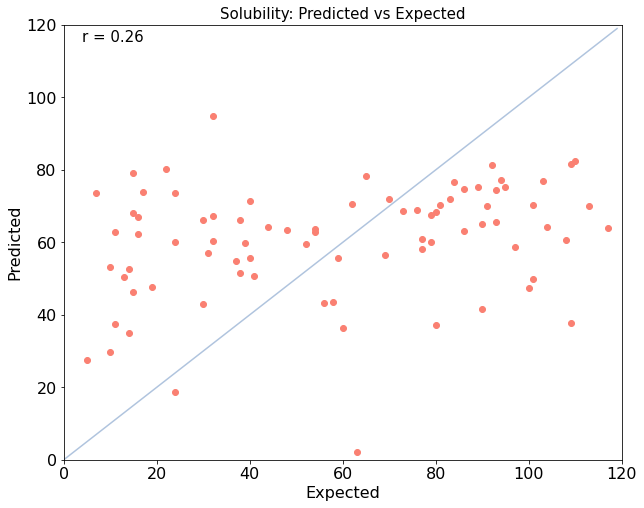

In [9]:
# Plot the R2 predicted and expected results
plot_pred_expected_results(y_test, y_pred)

In [10]:
# Check the Adjusted R2

n_observations = len(y_train)
n_independent_variables = x_train.shape[1]

for cross_val_r2 in scores['test_r2']:
    Adj_r2 = get_adj_r2(n_observations=n_observations, n_independent_variables=n_independent_variables, r2_score=cross_val_r2)
    print(Adj_r2)

-0.022799699824254338
0.1293487812459032
0.1216618881353313
0.16013320558446642
0.06831283212384998
-0.5326170268046035
0.10850083798198296
0.0741087614654734
0.19612061387038215
0.11693162680523905


# Saving trained model

In [11]:
filename = '../models/lr_model.joblib'
joblib.dump(lm, filename)

['../models/lr_model.joblib']

In [12]:
# Remove features with high p value

x_train_copy = x_train.copy()
x_test_copy = x_test.copy()

X2 = sm.add_constant(x_train_copy)
est = sm.OLS(y_train, X2)
est2 = est.fit()

p_values = est2.pvalues

while p_values[p_values > 0.05].empty == False:
    max_p_value = p_values[p_values > 0.05].idxmax()

    x_train_copy.drop(columns=[max_p_value], inplace=True)
    x_test_copy.drop(columns=[max_p_value], inplace=True)

    X2 = sm.add_constant(x_train_copy)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()

    p_values = est2.pvalues


print(p_values)

const          0.038679
fa_atr         0.001714
fa_elec        0.001498
fa_sol         0.029604
hbond_bb_sc    0.001010
hbond_sc       0.005394
hbond_sr_bb    0.000185
dtype: float64


In [13]:
# Create RL model without the columns with p_value higher than 0.05

lm_removed_high_corr = LinearRegression()
lm_removed_high_corr.fit(x_train_copy, y_train)

y_pred = lm_removed_high_corr.predict(x_test_copy)
r2_removed_high_corr = metrics.r2_score(y_test, y_pred)

print(r2_removed_high_corr)

0.10194067392097961


In [14]:
# Save files without the p values above 0.05
folder_path = "../data/"
x_train_copy.to_csv(folder_path + 'x_train_p_value_removed.csv', index=False)
x_test_copy.to_csv(folder_path + 'x_test_p_value_removed.csv', index=False)